# **Проект "Рыночная стоимость авто"**

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей.

# **1. Вводная информация**

## **1.1. Задача**

Нам нужно построить модель для определения стоимости авто. 

**Заказчику важны:**
- качество предсказания;
- скорость предсказания;
- время обучения.

## **1.2. Описание набора данных**

**Признаки:**
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `NotRepaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак:**
- `Price` — цена (евро)

## **1.3. План работы**

Коротко опишем наш пайплайн работы:

1. Загрузим и познакомимся с данными, оценим их качество и состояние;
2. Выполним необходимую предобработу данных;
3. Определим явные и скрытые взаимосвязи;
4. Определим признаки, которые лучше всего подходят для обучения;
5. Определим сетку параметров для поиска наиболее удачной модели;
6. Предварительное обучение и подбор параметров произведем для начала на небольшом количестве данных;
7. Проверим два основных варианта модели линейной регрессии и градиентного бустинга (LightGBM).
8. Проанализируем и сравним характеристики моделей: точность предсказания, скорость работы и качество моделей.

Выбранная метрика для оценки качества: `RMSE`.


# **2. Настройка рабочего пространства**

## **2.1. Импорт библиотек и настройка рабочего пространства.**

In [45]:
from IPython.display import display, HTML 
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from typing import List, Any, Callable, Dict, Optional, Union

from phik import phik_matrix

from scipy.stats import ttest_ind, levene, bartlett, fligner

import lightgbm as lgb
from sklearn.linear_model import LinearRegression

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.preprocessing import StandardScaler, OneHotEncoder, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_squared_error


In [46]:
warnings.filterwarnings('ignore') # чтобы не было красный полей с предупреждениями об устаревших библиотеках
# %matplotlib inline
plt.ion() # принудительное отображение графиков matplotlib в VS Code
pd.set_option("display.max_columns", None) # чтобы сам df был пошире
pd.set_option('display.max_colwidth', None) # чтобы df колонки были пошире
pd.set_option('display.float_format', '{:.3f}'.format) # округление чисел в df, чтобы числа не печатал экспоненциально
pd.options.display.expand_frame_repr = False # для принта чтобы колонки не переносил рабоатет тольок в vs code, in jupyter notebook получается каша

## **2.2. Загрузка данных**

In [47]:
try:
    df = pd.read_csv('datasets/autos.csv')
    print("Данные загружены с домашнего компьютера")
except (FileNotFoundError, OSError):
    # Альтернативный путь для запуска из Интернета
    df = pd.read_csv('/datasets/autos.csv')
    print("Данные загружены из Интернета")

Данные загружены с домашнего компьютера


## **2.3. Сокращение размерности**

Для ускорения предварительной обработки и обучения сократим датасет до 10_0000

In [48]:
# df = df[:100_000]

## **2.3. Деление данных на выборки**

In [49]:
# Разделение всего датафрейма
train_df, test_df = train_test_split(df, test_size=0.25, random_state=42)

print(f'Train: {train_df.shape[0]} строк')
print(f'Test: {test_df.shape[0]} строк')

Train: 265776 строк
Test: 88593 строк


Для удобства итераций и предобработки создадим словарь датафреймов.

In [50]:
df_dict = {
            'train_df': train_df, 
            'test_df': test_df, 
            }

# **3. EDA: исследовательский анализ данных**

# **3.1. Оценка качества представленных данных**

In [51]:
df.info()   

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [52]:
df

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354364,2016-03-21 09:50:58,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,2016-03-21 00:00:00,0,2694,2016-03-21 10:42:49
354365,2016-03-14 17:48:27,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,2016-03-14 00:00:00,0,39576,2016-04-06 00:46:52
354366,2016-03-05 19:56:21,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,2016-03-05 00:00:00,0,26135,2016-03-11 18:17:12
354367,2016-03-19 18:57:12,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,2016-03-19 00:00:00,0,87439,2016-04-07 07:15:26


In [53]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000,354369.000,354369.000,354369.000,354369.000,354369.000,354369.000
mean,4416.657,2004.234,110.094,128211.173,5.715,0.000,50508.689
std,4514.159,90.228,189.850,37905.342,3.726,0.000,25783.096
min,0.000,1000.000,0.000,5000.000,0.000,0.000,1067.000
25%,1050.000,1999.000,69.000,125000.000,3.000,0.000,30165.000
50%,2700.000,2003.000,105.000,150000.000,6.000,0.000,49413.000
75%,6400.000,2008.000,143.000,150000.000,9.000,0.000,71083.000
max,20000.000,9999.000,20000.000,150000.000,12.000,0.000,99998.000


## **3.2. Вывод о качестве данных**

**Качество данных УДОВЛЕТВОРИТЕЛЬНОЕ с серьезными проблемами**

**1. Аномальные значения и подозрительные значения:**

`Price`:  min=0, max=20000 (цена 0€ — явная ошибка)

`Power`: min=0, max=20000 (мощность 0 и 20000 л.с. — нереально)

`RegistrationYear`: min=1000, max=9999 (автомобили из 1000 и 9999 года — ошибка), двузначные отображения года (90), вероятно, тоже требуют внимания и коррекции.

`RegistrationMonth`: min=0 (месяц 0 не существует), такх значений порядка 10% - 35.000 обяъвлений с месяцем регистрации 0

`Kilometer`: 75% значений = 150000 км (округление/ограничение)

`NumberOfPictures`: все значения = 0 (признак бесполезен)

**2. Пропуски данных:**

`VehicleType`: 37490 пропусков (10.6%)

`Gearbox`: 19833 пропусков (5.6%)

`Model`: 19705 пропусков (5.6%)

`FuelType`: 32895 пропусков (9.3%)

`Repaired`: 71154 пропусков (20.1%) — критично!

**3. Несогласованность:**

`Repaired` в датасете, но в описании `NotRepaired` (ПОЧЕМУ? инверсия логики?)

**4. Выбросы: как поступить с ними?**

- Удалять выбросы верно, если выброс - это шум или ошибка;

- удалять выброс нельзя если это редкое, но рельное событие.

Проблема в том, что могути попадаться машины или спорткары или коллекционные машины, или действиельно с большим или очень маленьким пробегом, и возхможно стоит соотносить с годом выпуска или попытаься определить релаьные пограничные значения.  


**Необходимые действия:**

- Удалить аномалии (Price <= 1, Power <= 1/1900, Year<1920, RegistrationMonth=0)

- Обработать пропуски (заполнение средним / удаление - проверить изменение качества модели)

- Исследовать распределение Kilometer

- Удалить `NumberOfPictures` (нулевая вариативность) и `DateCrawled`, `DateCreated`, `LastSeen` (технические даты)

**Вывод:** Данные требуют серьезной предобработки перед обучением модели.

## **3.3. Создание pipeline для предобработки**

Произведем предобработку данных на классах в PipeLine. Для этого создадим следующие классы:

- `DecimalPointChanger` - проверяет каждое значение столбца на наличие правильного разделителя дроби, в случае если будет найдена запятая - заменит ее на точку;
- `OutlierRemover` - удалит выбросы;
- `ImplicitDuplicatesViewer` - отобразит список уникальных нечисловых значений каждого столбца, что должно помочь опредлелить неявные дубликаты в столбцах;
- `DuplicateRemover` - удалит явные дубликаты;
- `MissingValueHandler` - обрабатывает пропуски на основе выбранной стратегии, по умолчанию, удаляет всю строку, если есть в ней пропуск;
- `ColumnRemover` - удаляет лишний столбцы из датафрейма;
- `FloatToIntChanger` - преобразует дробное число в целочисленное.

Эти классы мы передадим в класс `EDAPreprocessor`, который станет основной состаляющей пайплайна EDA_Preprocessor_pipline, который будет производить предобработку данных. Зпуск пайплайна буддет вызываться функией  `run_preprocessor()`.

In [54]:
class MistakeCorrector(BaseEstimator, TransformerMixin):
    """Класс для исправления ошибок в данных. Принимает опционально словарь с правильными значениями, список колонок, а также прямое указания действия в виде lambda функции."""
    def __init__(
            self, 
            columns: List[str], 
            values_dict: Optional[Dict[Any, Any]] = None, 
            func: Optional[Callable] = None,
            strategy: str = 'dict',
            skip_on_test: bool = False
            ):
        
        """
        Инициализация исправителя ошибок.
        
        Parameters:
        - columns: список столбцов для обработки (обязательный)
        - values_dict: словарь {некорректное_значение: корректное_значение} (опционально)
        - func: функция для преобразования значений (например, lambda x: x * 10) (опционально)
        - strategy: стратегия обработки ('dict' или 'func'), по умолчанию 'dict'.
        """

        if not columns:
            raise ValueError("Параметр 'columns' не может быть пустым. Необходимо указать список столбцов, в которых проихзводить исправления значений")
            
        if strategy not in ['dict', 'func', 'auto']:
            raise ValueError("strategy должен быть 'dict' - для исправления значений по словарю, или 'func' - для определния метода вручную снаружи, например, lambda x: x * 10")

        self.values_dict = values_dict or {}
        self.columns = columns
        self.func = func
        self.strategy = strategy
        self.skip_on_test = skip_on_test
        self.fill_values = {}  # ← для хранения вычисленных значений
    

    def fit(self, X: pd.DataFrame, y=None, **kwargs):
        """Сохраняет корректные значения для замены"""
        if self.strategy == 'auto':
            for col in self.columns:
                for invalid_val, method in self.values_dict.items():
                    if method == 'median':
                        self.fill_values[(col, invalid_val)] = X[col][X[col] != invalid_val].median()
                    elif method == 'mode':
                        self.fill_values[(col, invalid_val)] = X[col][X[col] != invalid_val].mode()[0]
        return self
    
    def transform(self, X: pd.DataFrame, y=None, name=None) -> pd.DataFrame:
        """Применяет исправления к данным на обеих выборках"""

        df = X.copy()
        
        for col in self.columns:
            if col not in df.columns:
                continue

            if self.strategy == 'auto':
                for invalid_val, method in self.values_dict.items():
                    mask = df[col] == invalid_val
                    if mask.any():
                        fill_val = self.fill_values[(col, invalid_val)]
                        print(f"- Заменено {mask.sum()} значений {invalid_val} в '{col}' на {fill_val:.0f} ({method})")
                        df.loc[mask, col] = fill_val
                        
            elif self.strategy == 'func' and self.func:
                df[col] = df[col].apply(self.func)
                
            elif self.strategy == 'dict' and self.values_dict:
                df[col] = df[col].replace(self.values_dict)
        
        return df

    def fit_transform(self, X, y: None = None, **fit_params):   # name=None передается через **fit_params, чтобы не ломать сигнатуру метода
        return self.fit(X, y).transform(X, **fit_params)

In [55]:
class DecimalPointChanger(BaseEstimator, TransformerMixin):
    """Класс для замены разделителя дроби в строковых столбцах для обеих выборок"""

    def __init__(self, columns: List[str], skip_on_test=False):
        """Инициализация заменщика дроби в строковых столбцах"""
        
        self.columns = columns  # список столбцов, в которых нужно заменить разделитель дроби
        self.skip_on_test = skip_on_test
    
    def fit_transform(self, X: Union[pd.DataFrame, np.array], y: None = None, **fit_params) -> np.ndarray:
        
        """Непосредственно заменяет разделитель дроби запятую на точку"""

        print('- Определяю необходимость замены запятой на точку')
        
        df = X.copy()

        # Если columns не указаны, обрабатываем все столбцы
        cols_to_process = self.columns if self.columns else df.columns

        for col in cols_to_process:
            if col in df.columns:
                # Проверяем, есть ли запятые в столбце
                if df[col].dtype == 'object' and df[col].str.contains(',').any():
                    df[col] = df[col].str.replace(',', '.').astype(float)
                    print(f'- Заменил запятую на точку в столбце {col}')
                    print(f'--- Значения в столбце {col}: {df[col].unique()}\n')
                else:
                    print(f'- В столбце {col} замена не требуется')
        
        print('- Обработка завершена\n')
        return df

In [56]:
class OutlierHandler(BaseEstimator, TransformerMixin):
    """Универсальный класс для обработки выбросов"""

    def __init__(
        self,
        skip_on_test=True,
        target_columns: Optional[List[str]] = None, 
        columns: Optional[List[str]] = None,
        method: str = 'IQR',
        action: str = 'winsorize',
        factor: float = 1.5,
        clip_quantiles: tuple = (0.01, 0.99),
        IQR_quantiles: tuple = (0.25, 0.75),
        extreme_factor: float = 3.0,
        min_valid_values: Optional[Dict[str, float]] = None,
        max_valid_values: Optional[Dict[str, float]] = None
    ):

        """
        Parameters:
        -----------
        columns: list of str optional, default=None (обрабатываются все числовые)
            Столбцы для обработки. Если None, обрабатываются все числовые столбцы.

        skip_on_test: bool, default=True
            Если True, то для тестовой выборки обрабатываются только target_columns (если они указаны), остальные колонки пропускаются. Если False, то обрабатываются все колонки
        
        target_columns: list of str optional, default=None 
            Список целевых колонок для тестовой выборки, которые нужно обработать. Если None, то на тесте ничего не обрабатывается.

        method: str, default='IQR'
            'IQR' или 'quantile'

        action: str, default='winsorize'
            'remove' (всю строку), 'nan', 'mean', 'clip' (замещение выбросов граничным значением), 'winsorize' (умная обработка)

        factor: float, default=1.5
            Множитель для IQR (только для IQR метода)    

        extreme_factor: float, default=3.0
            Множитель для экстремальных выбросов (только для winsorize)

        IQR_quantiles: tuple, default=(0.25, 0.75)
            Квантили для IQR метода

        clip_quantiles: tuple, default=(0.01, 0.99)
            Квантили для clip метода

        min_valid_values: dict, default=None
            Словарь с минимально допустимыми значениями для каждой колонки 

        max_valid_values: dict, default=None
            Словарь с максимально допустимыми значениями для каждой колонки
        """

        self.skip_on_test = skip_on_test
        self.target_columns = target_columns or []
        self.target_handling = bool(self.target_columns)  # флаг, указывающий, нужно ли обрабатывать только целевые колонки в тесте
        self.columns = columns
        self.method = method
        self.action = action
        self.factor = factor
        self.extreme_factor = extreme_factor
        self.clip_quantiles = clip_quantiles
        self.IQR_quantiles = IQR_quantiles
        self.bounds_dict = {}                   # словарь с границами, который был создан в методе fit() выбросов может и не быть
        self.means_dict = {}
        self.min_valid_values = min_valid_values
        self.max_valid_values = max_valid_values


    def fit(self, X, y=None, **kwargs):
        """Запоминает границы. Только для train выборки"""

        X_clean = X.copy()
    
        # Удаляем физически невозможные значения ПЕРЕД расчетом IQR
        if self.min_valid_values:
            for col, min_val in self.min_valid_values.items():
                if col in X_clean.columns:
                    X_clean = X_clean[X_clean[col] >= min_val]
        
        if self.max_valid_values:
            for col, max_val in self.max_valid_values.items():
                if col in X_clean.columns:
                    X_clean = X_clean[X_clean[col] <= max_val]

        cols = self.columns if self.columns else X.select_dtypes(include=[np.number]).columns
        
        if self.method == 'quantile':
            for col in cols:
                lower = X[col].quantile(self.clip_quantiles[0])
                upper = X[col].quantile(self.clip_quantiles[1])
                self.bounds_dict[col] = (lower, upper)
        else:  # IQR
            for col in cols:
                Q1 = X[col].quantile(self.IQR_quantiles[0])
                Q3 = X[col].quantile(self.IQR_quantiles[1])
                IQR = Q3 - Q1
                lower = Q1 - self.factor * IQR
                upper = Q3 + self.factor * IQR
                self.bounds_dict[col] = (lower, upper)
        
        if self.action == 'mean':
            for col in cols:
                self.means_dict[col] = X[col].mean()
        
        return self


    def transform(self, X, name=None):
        """Применяет обработку. Для test пропускает все, кроме target_columns"""

        X_transformed = X.copy()
        cols = self.columns if self.columns else X.select_dtypes(include=[np.number]).columns

        # Если test - обрабатываем только target_columns
        if self.skip_on_test and name and 'test' in name.lower() and self.target_handling:
            cols = [col for col in cols if col in self.target_columns]
            if not cols:
                print(f"- Пропускаю обработку выбросов для {name}")
                return X
            print(f"- Test выборка: обрабатываю только целевые колонки: {cols}")

        # БЛОК 1: Удаление физически невозможных значений (СНАЧАЛА)
        # Удаление физически невозможных значений (например, возраст < 0 или пробег > 1000000, пробег < 0, цена < 0, год  выпуск авто 1500 и т.д.)
        if self.min_valid_values:
            for col, min_val in self.min_valid_values.items():
                if col in cols and col in X_transformed.columns:
                    invalid_mask = X_transformed[col] < min_val
                    
                    if invalid_mask.any():
                        invalid_values = X_transformed.loc[invalid_mask, col]
                        count = invalid_mask.sum()
                        min_invalid = invalid_values.min()
                        max_invalid = invalid_values.max()
                        
                        print(f"\n⚠️ Обнаружены недопустимые значения в '{col}':")
                        print(f"   Количество: {count} строк")
                        print(f"   Недопустимый диапазон: [{min_invalid:.2f} - {max_invalid:.2f}]")
                        print(f"   Минимально допустимое значение: {min_val}")
                        print(f"   → Строки будут удалены как явный шум (независимо от IQR)")
                        
                        X_transformed = X_transformed[~invalid_mask]

        if self.max_valid_values:
            for col, max_val in self.max_valid_values.items():
                if col in cols and col in X_transformed.columns:
                    invalid_mask = X_transformed[col] > max_val
                    
                    if invalid_mask.any():
                        invalid_values = X_transformed.loc[invalid_mask, col]
                        count = invalid_mask.sum()
                        min_invalid = invalid_values.min()
                        max_invalid = invalid_values.max()
                        
                        print(f"\n⚠️ Обнаружены недопустимые значения в '{col}':")
                        print(f"   Количество: {count} строк")
                        print(f"   Недопустимый диапазон: [{min_invalid:.2f} - {max_invalid:.2f}]")
                        print(f"   Максимально допустимое значение: {max_val}")
                        print(f"   → Строки будут удалены как явный шум (независимо от IQR)")
                        
                        X_transformed = X_transformed[~invalid_mask]


        # Этот код не ищет выбросы — он просто проверяет, есть ли выбросы в каждой колонке.
        # Чтобы Вывести предупреждение ниже, в каких колонках найдены выбросы
        outlier_cols = []
        for col in cols:
            if col in self.bounds_dict:
                lower, upper = self.bounds_dict[col]
                outliers = (X_transformed[col] < lower) | (X_transformed[col] > upper)
                if outliers.any():
                    outlier_cols.append(col)
        
        if not outlier_cols:
            print('- Выбросы не обнаружены')
            return X_transformed
        
        print(f'\n- Обнаружены выбросы в столбцах: {outlier_cols}')
        print(f'- Метод: {self.method}, Действие: {self.action}\n')


        # ВЫВОД ГРАНИЦ ДЛЯ КАЖДОЙ КОЛОНКИ
        for col in outlier_cols:
            if col in self.bounds_dict:
                lower, upper = self.bounds_dict[col]
                print(f'  Нормальные пределы для {col}: [{lower:.2f} - {upper:.2f}]')
        print()
        

        # ВИНЗОРИЗАЦИЯ (умная обработка)
        if self.action == 'winsorize':
            print('- Применяю винзоризацию (мягкие → clip, экстремальные → remove)')
            X_transformed['outlier_status'] = 'normal'
            
            for col, (lower, upper) in self.bounds_dict.items():
                # Границы для экстремальных выбросов
                IQR = upper - lower
                extreme_lower = lower - self.extreme_factor * IQR
                extreme_upper = upper + self.extreme_factor * IQR
                
                # Мягкие выбросы → винзоризация (clipping)
                mild_outliers = ((X_transformed[col] < lower) & (X_transformed[col] >= extreme_lower)) | \
                               ((X_transformed[col] > upper) & (X_transformed[col] <= extreme_upper))
                X_transformed.loc[mild_outliers, 'outlier_status'] = 'mild'
                X_transformed.loc[mild_outliers, col] = X_transformed.loc[mild_outliers, col].clip(lower, upper)
                
                # Экстремальные выбросы → маркировка для удаления
                extreme_outliers = (X_transformed[col] < extreme_lower) | (X_transformed[col] > extreme_upper)
                X_transformed.loc[extreme_outliers, 'outlier_status'] = 'extreme'
            
            # Удаляем только экстремальные
            n_extreme = (X_transformed['outlier_status'] == 'extreme').sum()
            if n_extreme > 0:
                print(f'Удалено экстремальных выбросов: {n_extreme}')
                X_transformed = X_transformed[X_transformed['outlier_status'] != 'extreme']
            
            X_transformed = X_transformed.drop('outlier_status', axis=1)
        

        # Остальные действия (clip, nan, mean, remove)
        elif self.action == 'clip':
            for col, (lower, upper) in self.bounds_dict.items():
                X_transformed[col] = X_transformed[col].clip(lower, upper)
        
        elif self.action == 'nan':
            for col, (lower, upper) in self.bounds_dict.items():
                outliers = (X_transformed[col] < lower) | (X_transformed[col] > upper)
                X_transformed.loc[outliers, col] = np.nan
        
        elif self.action == 'mean':
            for col, (lower, upper) in self.bounds_dict.items():
                outliers = (X_transformed[col] < lower) | (X_transformed[col] > upper)
                X_transformed.loc[outliers, col] = self.means_dict[col]
        
        elif self.action == 'remove':
            if self.columns is None:
                mask = pd.Series([True] * len(X_transformed), index=X_transformed.index)
                for col, (lower, upper) in self.bounds_dict.items():
                    outliers = (X_transformed[col] < lower) | (X_transformed[col] > upper)
                    mask &= ~outliers
                X_transformed = X_transformed[mask]
                X_transformed = X_transformed.reset_index(drop=True)
            else:
                for col, (lower, upper) in self.bounds_dict.items():
                    outliers = (X_transformed[col] < lower) | (X_transformed[col] > upper)
                    X_transformed = X_transformed[~outliers]
                    X_transformed = X_transformed.reset_index(drop=True)
        
        return X_transformed


    def fit_transform(self, X, y=None, **fit_params):   # name=None передается через **fit_params, чтобы не ломать сигнатуру метода
        return self.fit(X, y).transform(X, **fit_params)


In [57]:
class ImplicitDuplicatesViewer(BaseEstimator, TransformerMixin):
    """Выводит уникальные значения каждого столбца для визуального определения неявных дубликатов только для тренировочной выборки"""

    def __init__(self, skip_on_test=True, columns: List[str] = None):
        """Инициализация определеителя неявных дуликатов"""
        self.columns = columns
        self.skip_on_test = skip_on_test


    def fit(self, X: pd.DataFrame, y: None = None):
        return self


    def transform(self, X: pd.DataFrame, y: None = None, name=None):
        """Выводит уникальные значения каждого столбца для визуального определения неявных дуликатов"""

        if self.skip_on_test and name and 'test' in name.lower():
            print(f"- Пропускаю проверку на неявные дубликаты для {name}")
            return X


        print('- Выполняю поиск неявных дубликатов в нечисловых столбцах')

        df = X.copy()

        if self.columns:
            for col in self.columns:
                if col in df.columns:
                    print(f'- Уникальные значения в столбце {col}: {sorted(X[col].unique().tolist())}\n')
            return X
        else: 
            # columns = X.select_dtypes(exclude=[np.number]).columns # проверить только нечисловвые ячейки
            for col in df.columns:
                print(f'- Уникальные значения в столбце {col}: {sorted(X[col].unique().tolist())}\n')
            return X
        
    def fit_transform(self, X, y: None = None, **fit_params):   # name=None передается через **fit_params, чтобы не ломать сигнатуру метода
        return self.fit(X, y).transform(X, **fit_params)

In [58]:
class DuplicateRemover(BaseEstimator, TransformerMixin):
    """Класс для удаления дубликатов только для тренировочной выборки"""

    def __init__(self, skip_on_test=True, columns: List[str] = None):
        """Инициализация удалителя дубликатов"""
        self.columns = columns
        self.skip_on_test = skip_on_test


    def fit(self, X: pd.DataFrame, y: None = None):
        return self


    def transform(self, X: pd.DataFrame, y: None = None, name=None):
        """Удаляет дубликаты только в тренировочной выборке"""

        if self.skip_on_test and name and 'test' in name.lower():
            print(f"- Пропускаю удаление дубликатов для {name}")
            return X
        
        duplicate_count = X.duplicated().sum()

        if duplicate_count:
            print(f'- Выявлено {duplicate_count} дубликатов')
            print('- Выполняю удаление дубликатов\n')

            if self.columns:
                X = X.drop_duplicates(subset=self.columns)                
            else:
                X = X.drop_duplicates()
            
            remaining_duplicates = X.duplicated().sum()
            print(f'- Осталось {remaining_duplicates} дубликатов\n')
        else:
            print('- Дубликатов не выявлено\n')
        
        return X  # ← теперь возвращаешь очищенный X

    
    def fit_transform(self, X, y: None = None, **fit_params):   # name=None передается через **fit_params, чтобы не ломать сигнатуру метода
        return self.fit(X, y).transform(X, **fit_params)

In [59]:
class MissingValueHandler(BaseEstimator, TransformerMixin):
    """Класс для обработки пропущенных значений в данных. Возможные варианты параметра strategy: mean, median, mode, drop, unknown. По умолчанию drop. Для обеих выборок."""

    def __init__(self, skip_on_test=False, strategy='mean', fill_value=None):
        """Инициализация обработчика пропущенных значений. По умолчанию заполняет средним значением.
        """
        self.skip_on_test = skip_on_test
        self.strategy = strategy
        self.fill_value = fill_value
        self.fill_values_ = {}  # для хранения значений для заполнения

    def fit(self, X: pd.DataFrame, y: None=None):
        """Запоминает значения из train"""
        if self.strategy == 'mean':
            self.fill_values_ = X.select_dtypes(include=[np.number]).mean().to_dict()
        elif self.strategy == 'median':
            self.fill_values_ = X.select_dtypes(include=[np.number]).median().to_dict()
        elif self.strategy == 'mode':
            self.fill_values_ = {col: X[col].mode()[0] for col in X.columns}
        elif self.strategy == 'unknown':
            self.fill_values_ = {}  # для unknown не нужно запоминать
        elif self.strategy == 'drop':
            self.fill_values_ = {}  # для drop не нужно запоминать
    
        return self
        
    def transform(self, X: pd.DataFrame, y: None = None, name=None, **fit_params):
        """Применяет значения, которые запомнил из train. Заполняет пропущенные значения или удаляет строки в тестовой выборке. режимы: mean, median, mode, drop"""
        
        df = X.copy()

        if self.strategy == 'unknown':
            for col in df.select_dtypes(include='object').columns:
                if df[col].isnull().any():
                    df[col] = df[col].fillna('unknown')

        # Стратегия drop — удаление строк
        if self.strategy == 'drop':
            null_count = df.isna().sum().sum()
            if null_count > 0 or df.eq(" ").any().any():
                print('- Нашел пропуски в данных\n')
                null_string_count = len(df[df.isna().any(axis=1)])
                display(df[df.isna().any(axis=1)])
                if len(df[df.eq(" ").any(axis=1)]) != 0:
                    display(df[df.eq(" ").any(axis=1)])
                
                null_string_percentage = null_string_count / len(df) * 100
                if null_string_percentage < 10:
                    print(f'- Выявлено {null_count} пропусков в {null_string_count} строках ({null_string_percentage:.2f}%). Удаляю\n')
                    df = df.dropna()
                    df = df[~df.eq(" ").any(axis=1)]
                    print(f'- Осталось {df.isna().sum().sum()} пропусков\n')
            else:
                print('- Пропусков не найдено\n')
            return df
        
        # Остальные стратегии — заполнение запомненными значениями
        for col, fill_value in self.fill_values_.items():
            if col in df.columns and df[col].isnull().any():
                count = df[col].isnull().sum()
                percent = (count / len(df)) * 100
                print(f"- '{col}': {count} пропусков ({percent:.1f}%). Заполняю '{self.strategy}' → {fill_value}")
                df[col] = df[col].fillna(fill_value)
        
        return df

    def fit_transform(self, X: pd.DataFrame, y: None = None, **fit_params):  # name=None передается через **fit_params, чтобы не ломать сигнатуру метода
        return self.fit(X, y).transform(X, **fit_params)
        

In [60]:
class ColumnRemover(BaseEstimator, TransformerMixin):
    """Удаляет лишние колонки, переданные в списке. Работает как для train, так и для test выборки""" 

    def __init__(self, columns: List[str], skip_on_test=False):
        self.columns = columns
        self.skip_on_test=skip_on_test

    def fit(self, X: pd.DataFrame, y: None=None, name=None):
        # Просто сохраняем информацию о столбцах для удаления
        return self

    def transform(self, X: pd.DataFrame, name=None):

        df = X.copy()

        for col in self.columns:
            if col in df.columns:
                df = df.drop(col, axis=1)
                print(f'- Удалил столбец {col}')
        return df

    def fit_transform(self, X: pd.DataFrame, y: None=None, **fit_params):  # name=None передается через **fit_params, чтобы не ломать сигнатуру метода
        return self.fit(X, y).transform(X, **fit_params)

In [61]:
class FloatToIntChanger(BaseEstimator, TransformerMixin):
    """
    Преобразует дробные значения в целочисленные (режим Multiplie - по умолчанию: 
    умножает на 100 и сохраняет как Int, simple: без умножения меняет тип) на основе переданного списка столбцов
    """    

    def __init__(self, columns, strategy, skip_on_test=False):
        self.columns = columns
        self.strategy = strategy
        self.skip_on_test = False


    def fit(self, X: pd.DataFrame, y=None):
        # Вызывается только для train. Просто сохраняем информацию о столбцах формально
        if isinstance(X, pd.DataFrame):
            self.feature_names_in_ = X.columns.tolist()
        else:
            # Если на входе массив, генерируем имена колонок
            self.feature_names_in_ = [f"col_{i}" for i in range(X.shape[1])]
        return self
    

    def transform(self, X: pd.DataFrame, y=None, name=None):

        if isinstance(X, pd.DataFrame):
            df = X.copy()
        else:
            # Восстанавливаем DataFrame из массива
            df = pd.DataFrame(X, columns=self.feature_names_in_)

        if self.strategy == 'simple':
            for col in self.columns:
                if col in df.columns:
                    print(f'\n - Меняю тип на int столбце {col}')
                    df = df[col].astype('int')
            return df

        if self.strategy == 'multiplie':
            for col in self.columns:
                if col in df.columns:
                    print(f'\n - Значения в столбце {col} умножаю на 100 ')
                    df[col] = (df[col] * 100).astype('int')
                else:
                    print(f'- Колонка {col} не найдена в данных')
            return df

    def fit_transform(self, X: pd.DataFrame, y=None, **fit_params):
        return self.fit(X, y).transform(X, **fit_params)

In [62]:
class EDAPreprocessor:
    """
    Основной класс пайплайна для предобработки данных
    """

    def __init__(self, func: Callable[..., Any] | None = None):
        self.steps = []  # список шагов предобработки, которые будут выполняться в пайплайне
        self.fitted_transformers = {}  # для хранения обученных трансформеров (запоминает что-то и делает)
        
    def add_mistake_corrector(
                                self, 
                                columns: List[str] | None = None,
                                values_dict: dict | None = None, 
                                func: Callable[..., Any] | None = None, 
                                strategy: str | None = None, 
                                skip_on_test: bool = False,
                                step_name: str =' Преобразование некорректных данных'):
        """Добавляет шаг исправления ошибок в препроцессор, принимает на вход список колонок, в которых произвести замены, словарь с неверными и верными значениями"""
        
        mistake_corrector = MistakeCorrector(
                                                columns=columns, 
                                                values_dict=values_dict, 
                                                func=func,
                                                strategy=strategy
            )
        self.steps.append((step_name, mistake_corrector))
        return self

    def add_column_remover(
            self, 
            columns: List[str], 
            skip_on_test: bool = False,
            step_name: str = 'Удаление столбцов'):
        
        column_remover=ColumnRemover(columns=columns)
        self.steps.append((step_name, column_remover))
        return self

    def add_float_to_int_changer(
            self, 
            columns:List[str] | None = None,
            strategy='multiplie', 
            skip_on_test: bool = False,
            step_name='Преобразование дробных чисел в целочисленное'):
        float_to_int_changer=FloatToIntChanger(columns, strategy)
        self.steps.append((step_name, float_to_int_changer))
        return self

    def add_decimal_point_changer(
            self, 
            columns:List[str] | None = None, 
            skip_on_test: bool = False,
            step_name='Замена запятой на точку в дробных числах при необходимости'):
        decimal_point_changer = DecimalPointChanger(columns)
        self.steps.append((step_name, decimal_point_changer))
        return self


    def add_missing_value_handler(
            self, 
            strategy='drop', 
            fill_value=None, 
            skip_on_test: bool = False,
            step_name='Проверка пропущенных значений'):
        """Добавляет обработчик пропущенных значений в препроцессор"""
        missing_handler = MissingValueHandler(strategy=strategy, fill_value=fill_value)
        self.steps.append((step_name, missing_handler))
        return self    


    def add_outlier_handler(
            self, 
            columns: Optional[List[str]] = None,
            target_columns:Optional[List[str]] = None,
            method: str = 'IQR',
            action: str = 'winsorize',
            factor: float = 1.5,
            extreme_factor: float = 3.0,
            min_valid_values: Optional[Dict[str, float]] = None,
            max_valid_values: Optional[Dict[str, float]] = None,
            skip_on_test: bool = True,
            step_name: str = 'Проверка на наличие выбросов'):
        '''Добавляет шаг обработки выбросов'''
        outlier_handler = OutlierHandler(columns=columns, method=method, action=action, factor=factor, extreme_factor=extreme_factor, min_valid_values=min_valid_values, max_valid_values=max_valid_values, skip_on_test=skip_on_test)
        self.steps.append((step_name, outlier_handler))
        return self

 
    
    def add_drop_duplicates(
            self, 
            skip_on_test: bool = True,
            step_name='Проверка на наличие явных дубликатов'):
        """Добавляет шаг удаления дуликатов"""
        duplicate_remover = DuplicateRemover(skip_on_test=skip_on_test)
        self.steps.append((step_name, duplicate_remover))
        return self
    

    def add_implicit_duplicates_viewer(
            self, 
            skip_on_test: bool = True,
            columns:List[str] | None = None, 
            step_name='Отображение неявных дубликатов и проверка на неоднородность данных'):
        """Добавляет шаг отображения уникальных значений каждого столбца для выявления неявных дуликатов визуально."""
        implict_duplicates_viewer = ImplicitDuplicatesViewer(columns=columns, skip_on_test=skip_on_test)
        self.steps.append((step_name, implict_duplicates_viewer))
        return self
    

    def add_custom_transformer(self, step_name: str, transformer):
        """Добавляет пользовательский трансформер в пайплан предобраотки"""
        self.steps.append((step_name, transformer))
        return self
    

    def fit_transform(self, X: pd.DataFrame, name, y: None=None):
        """Обучает все трансформеры пайплайна (запоминает единые параметры и условия исполнения - консистентность). Принимает df и целевую переменную опционально."""

        df = X.copy()

        for i, (step_name, transformer) in enumerate(self.steps):
            print(f'\nИсполнение шага {i+1}: {step_name}')
            df = transformer.fit_transform(df, name=name)
            self.fitted_transformers[step_name] = transformer

        return df

In [63]:
EDA_Preprocessor_pipeline = (
    EDAPreprocessor()  
    .add_mistake_corrector(columns=['RegistrationMonth'], values_dict={0: 'median'}, strategy='auto', skip_on_test=False)
    .add_column_remover(columns=['DateCrawled', 'DateCreated', 'LastSeen', 'NumberOfPictures'], skip_on_test=False)
    .add_decimal_point_changer()                            
    .add_outlier_handler(skip_on_test=True, target_columns=['Price'], method='IQR', action='winsorize', factor=1.5, extreme_factor=3.0, min_valid_values={'Price': 1, 'Power': 1, 'RegistrationYear': 1920}, max_valid_values={'Power': 1900, 'RegistrationYear': 2025}) 
                                           # IQR, clip   # remove, nan, mean, clip, winsorize                                  
    .add_missing_value_handler(skip_on_test=False, strategy='unknown')   # на тестовой только заполнять, никогда не удалять         
                                                   # mean, median, mode, unknown, drop
    .add_drop_duplicates(skip_on_test=True)                                    
    .add_implicit_duplicates_viewer(columns=None, skip_on_test=True)           

)

print('Вот таким у нас получился предобработчик данных.\n')

print("Шаги в пайплайне:\n")
for i, (name, step) in enumerate(EDA_Preprocessor_pipeline.steps):
    print(f"{i+1}. {name}: {step}\n")

Вот таким у нас получился предобработчик данных.

Шаги в пайплайне:

1.  Преобразование некорректных данных: MistakeCorrector(columns=['RegistrationMonth'], strategy='auto',
                 values_dict={0: 'median'})

2. Удаление столбцов: ColumnRemover(columns=['DateCrawled', 'DateCreated', 'LastSeen',
                       'NumberOfPictures'])

3. Замена запятой на точку в дробных числах при необходимости: DecimalPointChanger(columns=None)

4. Проверка на наличие выбросов: OutlierHandler(max_valid_values={'Power': 1900, 'RegistrationYear': 2025},
               min_valid_values={'Power': 1, 'Price': 1,
                                 'RegistrationYear': 1920},
               target_columns=[])

5. Проверка пропущенных значений: MissingValueHandler(strategy='unknown')

6. Проверка на наличие явных дубликатов: DuplicateRemover()

7. Отображение неявных дубликатов и проверка на неоднородность данных: ImplicitDuplicatesViewer()



In [64]:
def run_preprocessor(df_dict=df_dict):
    """Производит предобработку всех датафреймов в цикле в пайплайне"""
    for name, df in df_dict.items():
        print('=' * 50)
        print(f' =>  Обработка датафрейма {name}')
        print('=' * 50)
        df_dict[name] = EDA_Preprocessor_pipeline.fit_transform(df, name)
        globals()[name] = df_dict[name]  # Перезаписывает глобальную переменную
        print(f'\nПроверка датафрейма {name}')
        display(df_dict[name].head())

run_preprocessor(df_dict)

 =>  Обработка датафрейма train_df

Исполнение шага 1:  Преобразование некорректных данных
- Заменено 28117 значений 0 в 'RegistrationMonth' на 6 (median)

Исполнение шага 2: Удаление столбцов
- Удалил столбец DateCrawled
- Удалил столбец DateCreated
- Удалил столбец LastSeen
- Удалил столбец NumberOfPictures

Исполнение шага 3: Замена запятой на точку в дробных числах при необходимости
- Определяю необходимость замены запятой на точку
- В столбце Price замена не требуется
- В столбце VehicleType замена не требуется
- В столбце RegistrationYear замена не требуется
- В столбце Gearbox замена не требуется
- В столбце Power замена не требуется
- В столбце Model замена не требуется
- В столбце Kilometer замена не требуется
- В столбце RegistrationMonth замена не требуется
- В столбце FuelType замена не требуется
- В столбце Brand замена не требуется
- В столбце Repaired замена не требуется
- В столбце PostalCode замена не требуется
- Обработка завершена


Исполнение шага 4: Проверка на нал

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
236946,10500.000,convertible,2008.000,manual,122.000,eos,87500,9,petrol,volkswagen,no,87719
257527,1650.000,sedan,1999.000,manual,122.000,c_klasse,125000,10,petrol,mercedes_benz,no,26382
178330,14422.500,bus,2012.000,manual,111.000,5_reihe,87500,8,gasoline,peugeot,no,89358
85439,9990.000,sedan,2007.000,auto,200.000,passat,87500,2,petrol,volkswagen,no,48165
46203,800.000,wagon,1997.000,manual,144.000,v70,150000,7,petrol,volvo,no,57612


 =>  Обработка датафрейма test_df

Исполнение шага 1:  Преобразование некорректных данных
- Заменено 9235 значений 0 в 'RegistrationMonth' на 6 (median)

Исполнение шага 2: Удаление столбцов
- Удалил столбец DateCrawled
- Удалил столбец DateCreated
- Удалил столбец LastSeen
- Удалил столбец NumberOfPictures

Исполнение шага 3: Замена запятой на точку в дробных числах при необходимости
- Определяю необходимость замены запятой на точку
- В столбце Price замена не требуется
- В столбце VehicleType замена не требуется
- В столбце RegistrationYear замена не требуется
- В столбце Gearbox замена не требуется
- В столбце Power замена не требуется
- В столбце Model замена не требуется
- В столбце Kilometer замена не требуется
- В столбце RegistrationMonth замена не требуется
- В столбце FuelType замена не требуется
- В столбце Brand замена не требуется
- В столбце Repaired замена не требуется
- В столбце PostalCode замена не требуется
- Обработка завершена


Исполнение шага 4: Проверка на налич

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode
294049,14580,wagon,2014.000,manual,122,leon,87500,3,petrol,seat,no,22089
76415,14250,wagon,2011.000,manual,140,a3,87500,6,gasoline,audi,unknown,45770
212563,2850,wagon,2001.000,manual,131,passat,150000,9,gasoline,volkswagen,no,38259
109307,50,small,1996.000,manual,60,corsa,150000,8,petrol,opel,yes,7957
248545,500,unknown,2016.000,manual,82,a_klasse,150000,2,petrol,mercedes_benz,unknown,49356


In [65]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 218549 entries, 236946 to 121958
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Price              218549 non-null  float64
 1   VehicleType        218549 non-null  object 
 2   RegistrationYear   218549 non-null  float64
 3   Gearbox            218549 non-null  object 
 4   Power              218549 non-null  float64
 5   Model              218549 non-null  object 
 6   Kilometer          218549 non-null  int64  
 7   RegistrationMonth  218549 non-null  int64  
 8   FuelType           218549 non-null  object 
 9   Brand              218549 non-null  object 
 10  Repaired           218549 non-null  object 
 11  PostalCode         218549 non-null  int64  
dtypes: float64(3), int64(3), object(6)
memory usage: 21.7+ MB


In [66]:
train_df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode
count,218549.000,218549.000,218549.000,218549.000,218549.000,218549.000
mean,4609.357,2003.376,118.621,133862.589,6.347,51331.395
std,4172.988,6.484,50.151,24825.843,3.233,25776.868
min,1.000,1985.500,1.000,87500.000,1.000,1067.000
25%,1300.000,1999.000,75.000,125000.000,4.000,30982.000
50%,3000.000,2003.000,110.000,150000.000,6.000,50226.000
75%,6900.000,2008.000,150.000,150000.000,9.000,72184.000
max,14422.500,2019.000,1800.000,150000.000,12.000,99998.000


### **3.5. Классификация признаков по типам**

Перед построением распределений признаков и обучений модели необходимо классифицировать их по способу обработки, а не по математической классификации: 

- **числовые**, 
- **категориальные**

**1. Числовые** — используются как есть:

- `RegistrationYear` — непрерывный

- `Power` — непрерывный

- `Kilometer` — дискретный (но обрабатывается как непрерывный)

- `RegistrationMonth` — дискретный

- `PostalCode` — числовой (но может быть категориальным, регион влияет на цену, но 99к уникальных значений, можно агрегировать)

**2. Категориальные** — требуют кодирования:

- `VehicleType` — номинальный (sedan, suv, coupe...)

- `Gearbox` — номинальный (manual, auto)

- `Model` — номинальный (golf, passat...)

- `FuelType` — номинальный (petrol, diesel...)

- `Brand` — номинальный (volkswagen, audi...)

- `Repaired` — бинарный (yes/no)

Разделим признаки на группы:

## **3.6. Оценка распределения признаков**

### **3.6.1. Распределение бинарных признаков**

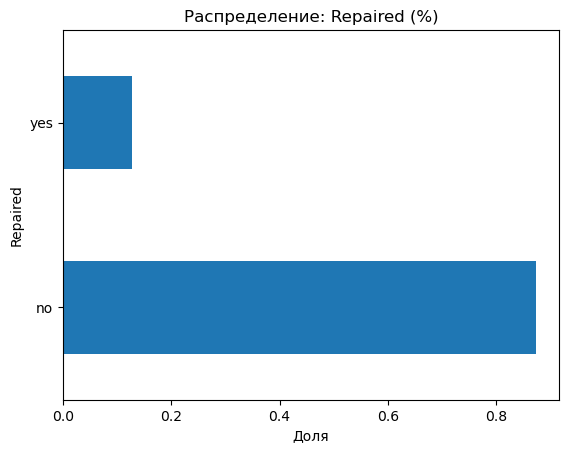

In [67]:
# Визуализация бинарных признаков: столбчатая диаграмма с двумя цветами и процентами
df['Repaired'].value_counts(normalize=True).plot.barh()
plt.title('Распределение: Repaired (%)')
plt.xlabel('Доля')
plt.show()


### **3.6.2. Распределение числовых признаков**

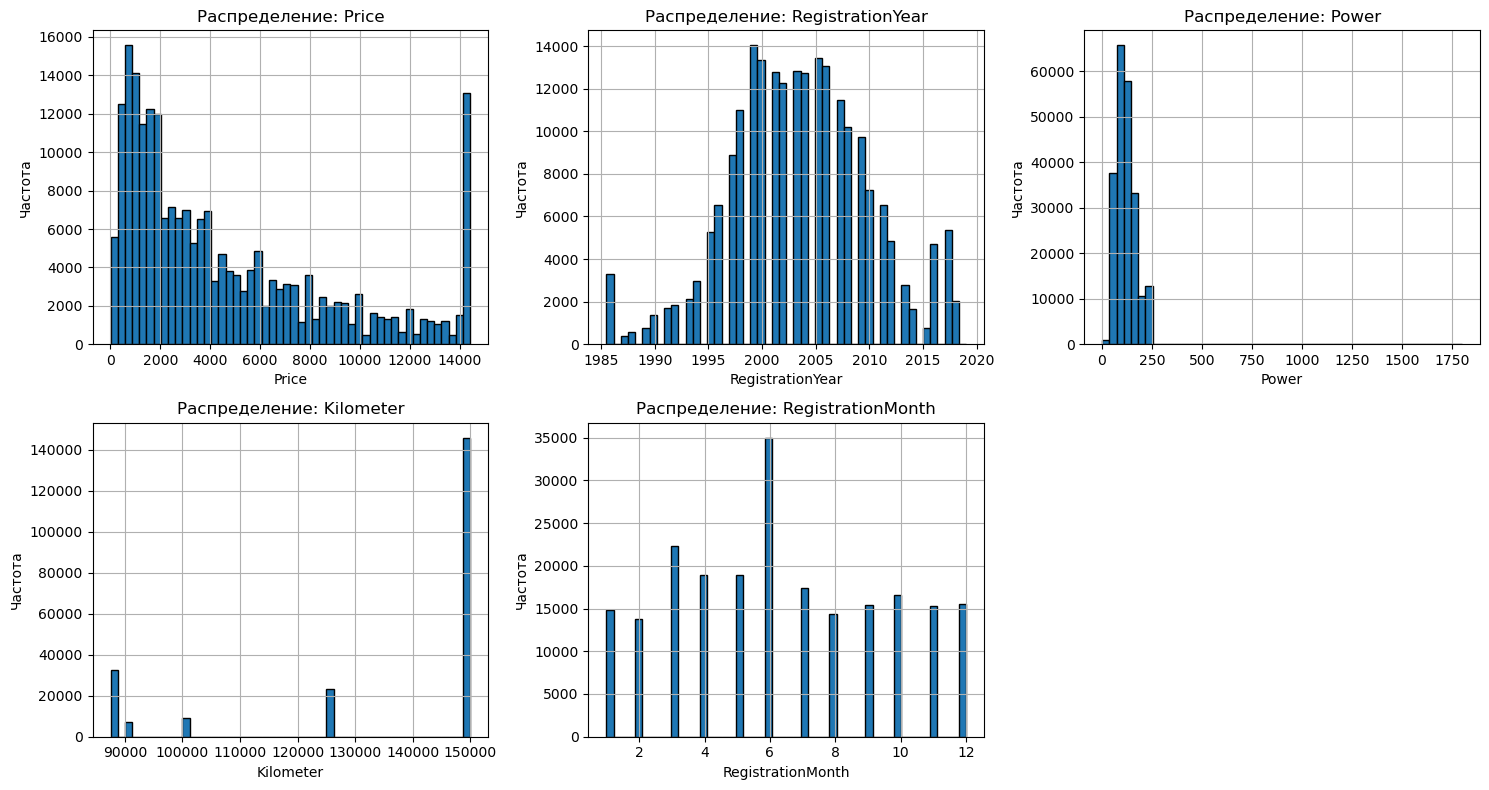

In [68]:
# Распределение числовых признаков
numerical_features = ['Price', 'RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, col in enumerate(numerical_features):
    train_df[col].hist(bins=50, ax=axes[i], edgecolor='black')
    axes[i].set_title(f'Распределение: {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Частота')

axes[-1].axis('off')  # Скрыть последний пустой график
plt.tight_layout()
plt.show()

### **3.6.4. Распределение категориальных признаков**

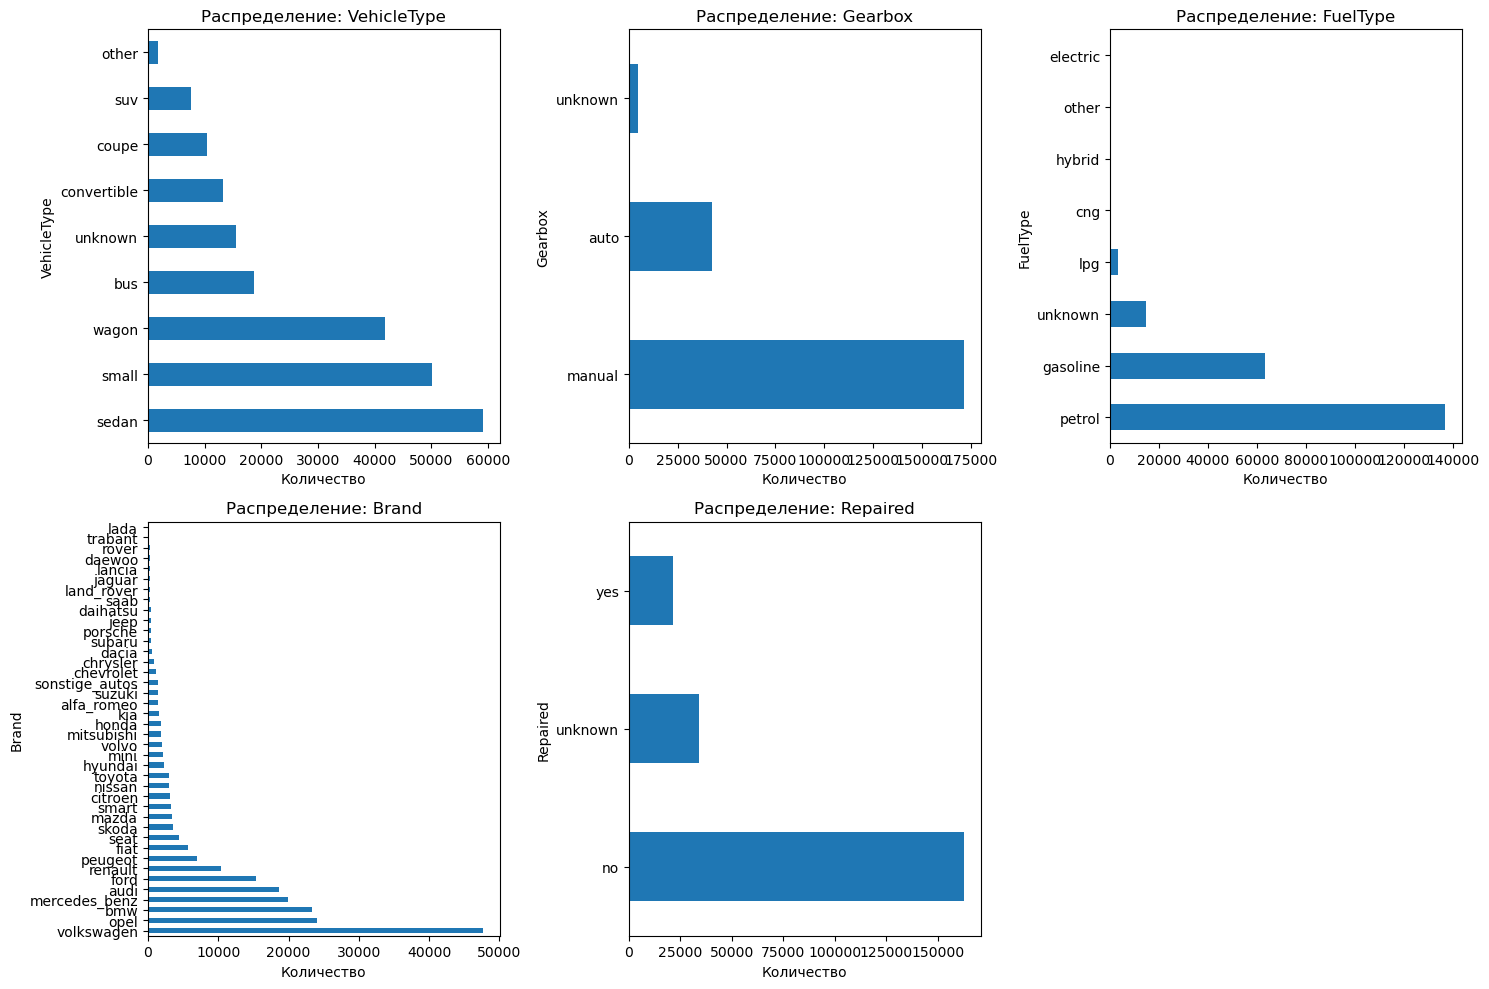

In [69]:
# Визуализация категориальных признаков
# Распределение категориальных признаков
categorical_features = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(categorical_features):
    train_df[col].value_counts().plot.barh(ax=axes[i])
    axes[i].set_title(f'Распределение: {col}')
    axes[i].set_xlabel('Количество')

axes[-1].axis('off')
plt.tight_layout()
plt.show()



## **3.7. Расшифровка визуализации распределения признаков**

Несмотря на предобработку данных и удаление выбросов в частности, 

практически все признаки имеют скошенное распределение: Бренд, год регистрации, Тип топлива, тип авто, мощномть, пробег.

Нормальное распределение у года регистрации. 

Вопросы остались по мощности авто что считать выбросами, будет ли данная модель предсказывать стоимость спорткаров или нет? Выбросы по мощности свыше 1500 л.с. мы удалили.

К числовым признакам, имеющим скошенное распределение мы применим RobustScaler

К категориальным признакам мы применим категорирование OneHotEncoder

Месяц регистрации особой ценности признак не несет.


**Рекомендации для обучения модели:**

## **3.8. Оценка статистических предобработанных данных** 

In [70]:
train_df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,PostalCode
count,218549.000,218549.000,218549.000,218549.000,218549.000,218549.000
mean,4609.357,2003.376,118.621,133862.589,6.347,51331.395
std,4172.988,6.484,50.151,24825.843,3.233,25776.868
min,1.000,1985.500,1.000,87500.000,1.000,1067.000
25%,1300.000,1999.000,75.000,125000.000,4.000,30982.000
50%,3000.000,2003.000,110.000,150000.000,6.000,50226.000
75%,6900.000,2008.000,150.000,150000.000,9.000,72184.000
max,14422.500,2019.000,1800.000,150000.000,12.000,99998.000


**Price (Целевая переменная):**

- Средняя цена 3529€, медиана 2450€ → правосторонняя асимметрия (дорогие авто тянут среднее вверх)

- Диапазон 1-14400€ после очистки выбросов

- 0% авто стоят 1100-4999€ (IQR)

**RegistrationYear (Год регистрации):**

- Средний возраст: 2003 год (≈20 лет на момент 2023)

- 50% авто: 1999-2006 годы

- Узкое std=5.9 → однородная выборка по возрасту

**Power (Мощность):**

- Средняя 115 л.с., медиана 110 л.с. → симметричное распределение

- 50% авто: 75-143 л.с. (типичные легковые)

- Max 250 л.с. после очистки

**Kilometer (Пробег):**

⚠️ Подозрительно: 75% авто имеют ровно 150000 км

- Медиана = 75-й перцентиль = max = 150000 → скорее всего округление/ограничение данных

- Реальный разброс только в нижних 25% (90000-150000)

**RegistrationMonth:**

- Равномерное распределение (медиана=6, среднее=6.35)

- Слабое влияние на цену (сезонность регистрации)

**PostalCode:**

- Широкий разброс (1067-99998) → географический фактор

- Может влиять на цену через региональные различия

**Ключевые выводы:**

- `Kilometer` требует внимания - возможна цензура данных на 150000

- `Price` асимметричен - рассмотреть log-трансформацию

- `RegistrationYear` и `Power` - потенциально сильные предикторы (низкая вариативность, четкие границы)

**Рекомендации для обучения модели**

**1. Feature Engineering**

- Создать возраст авто (сильнее влияет, чем год)

In [71]:
train_df['Age'] = 2023 - train_df['RegistrationYear']
test_df['Age'] = 2023 - test_df['RegistrationYear']

**2. Трансформация целевой переменной**

- `Price` асимметричен (mean > median) → log-трансформация

`y_train = np.log1p(train['Price'])`  для `LinearRegression`

**3. Масштабирование признаков**
- Для `LinearRegression` - обязательно StandardScaler
`Power` (1-250), `RegistrationYear` (1986-2019), `PostalCode` (1067-99998) - разные масштабы

- Для LightGBM - не нужно (работает с деревьями)

**5. Выбор модели**

- `LinearRegression`: быстрая, но требует log(Price), масштабирования, OHE

- `LightGBM`: лучше для нелинейных зависимостей, не требует предобработки, обрабатывает Kilometer=150000 автоматически

**6. Признаки для удаления**

- `RegistrationMonth` - слабое влияние (std=3.2, равномерное распределение)
- `PostalCode` - высокая кардинальность, может переобучить (группировать по регионам)


Итого: LightGBM предпочтительнее - не требует трансформаций.

In [72]:
train_df.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode,Age
236946,10500.000,convertible,2008.000,manual,122.000,eos,87500,9,petrol,volkswagen,no,87719,15.000
257527,1650.000,sedan,1999.000,manual,122.000,c_klasse,125000,10,petrol,mercedes_benz,no,26382,24.000
178330,14422.500,bus,2012.000,manual,111.000,5_reihe,87500,8,gasoline,peugeot,no,89358,11.000
85439,9990.000,sedan,2007.000,auto,200.000,passat,87500,2,petrol,volkswagen,no,48165,16.000
46203,800.000,wagon,1997.000,manual,144.000,v70,150000,7,petrol,volvo,no,57612,26.000


## **3.8. Корреляция данных**

In [73]:
interval_cols = interval_cols = ['Price', 'Power', 'Kilometer', 'PostalCode', 'Age'] # только дробные числа, или которые не в силах посчитать руками (если очень много значений, значит интервальный тип)

phik_corr = train_df.phik_matrix(interval_cols=interval_cols)
phik_corr     

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,PostalCode,Age
Price,1.000,0.274,0.668,0.291,0.287,0.582,0.366,0.088,0.264,0.367,0.357,0.091,0.702
VehicleType,0.274,1.000,0.678,0.380,0.232,0.896,0.201,0.132,0.419,0.588,0.355,0.065,0.593
RegistrationYear,0.668,0.678,1.000,0.207,0.132,0.663,0.567,0.150,0.442,0.334,0.355,0.080,1.000
Gearbox,0.291,0.380,0.207,1.000,0.547,0.623,0.018,0.147,0.207,0.519,0.283,0.087,0.165
Power,0.287,0.232,0.132,0.547,1.000,0.519,0.051,0.036,0.065,0.369,0.082,0.041,0.098
Model,0.582,0.896,0.663,0.623,0.519,1.000,0.470,0.141,0.539,0.998,0.270,0.210,0.651
Kilometer,0.366,0.201,0.567,0.018,0.051,0.470,1.000,0.055,0.246,0.327,0.096,0.032,0.490
RegistrationMonth,0.088,0.132,0.150,0.147,0.036,0.141,0.055,1.000,0.128,0.075,0.255,0.027,0.113
FuelType,0.264,0.419,0.442,0.207,0.065,0.539,0.246,0.128,1.000,0.327,0.199,0.053,0.366
Brand,0.367,0.588,0.334,0.519,0.369,0.998,0.327,0.075,0.327,1.000,0.136,0.177,0.379


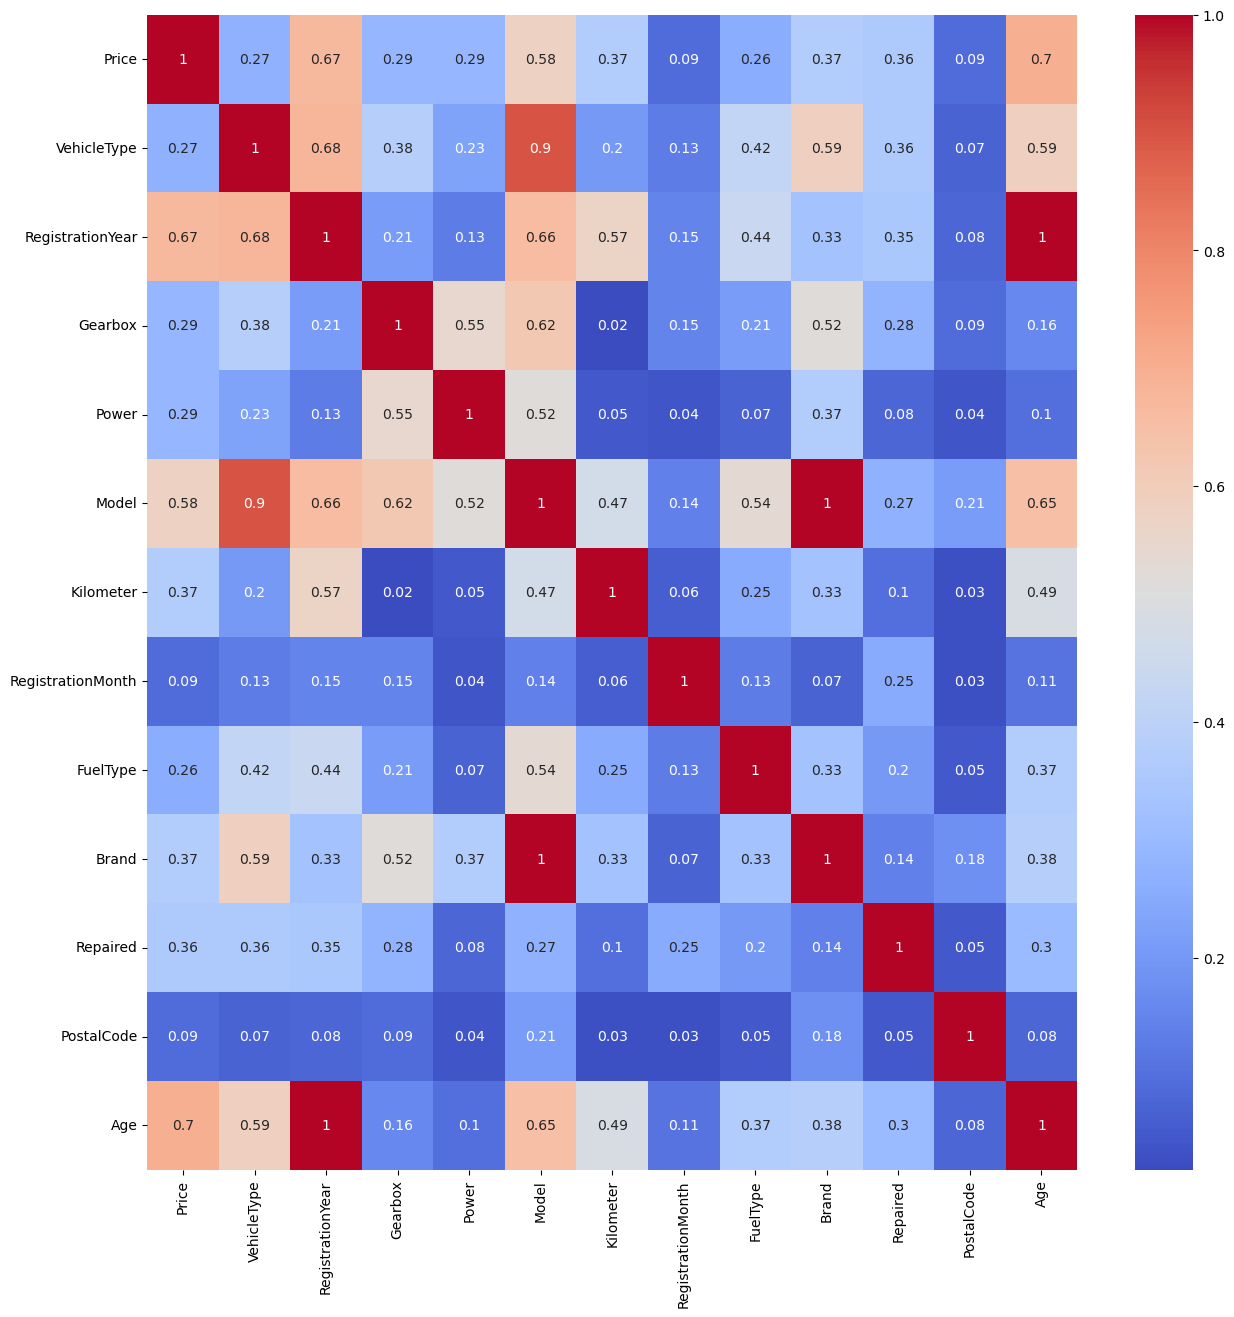

In [74]:
plt.figure(figsize=(15, 15))
sns.heatmap(phik_corr.round(2), annot=True, cmap='coolwarm')
plt.show()

**Мультиколлинеарность наблюдается среди признаков:**

- `RegistrationYear` и `Age` (возраст = 2023 - год) - почти полная корреляция
- `Brand` и `Model` 
- `Kilometer` & `Kilometer_Max`

**Высокая корреляция с целевым признаком у:**

- `Age` - 0.67
- `RegistrationYear` - 0.63  (но модель lgbm с ним обучается хуже)
- `Model` - 0.58
- `Power` - 0.55

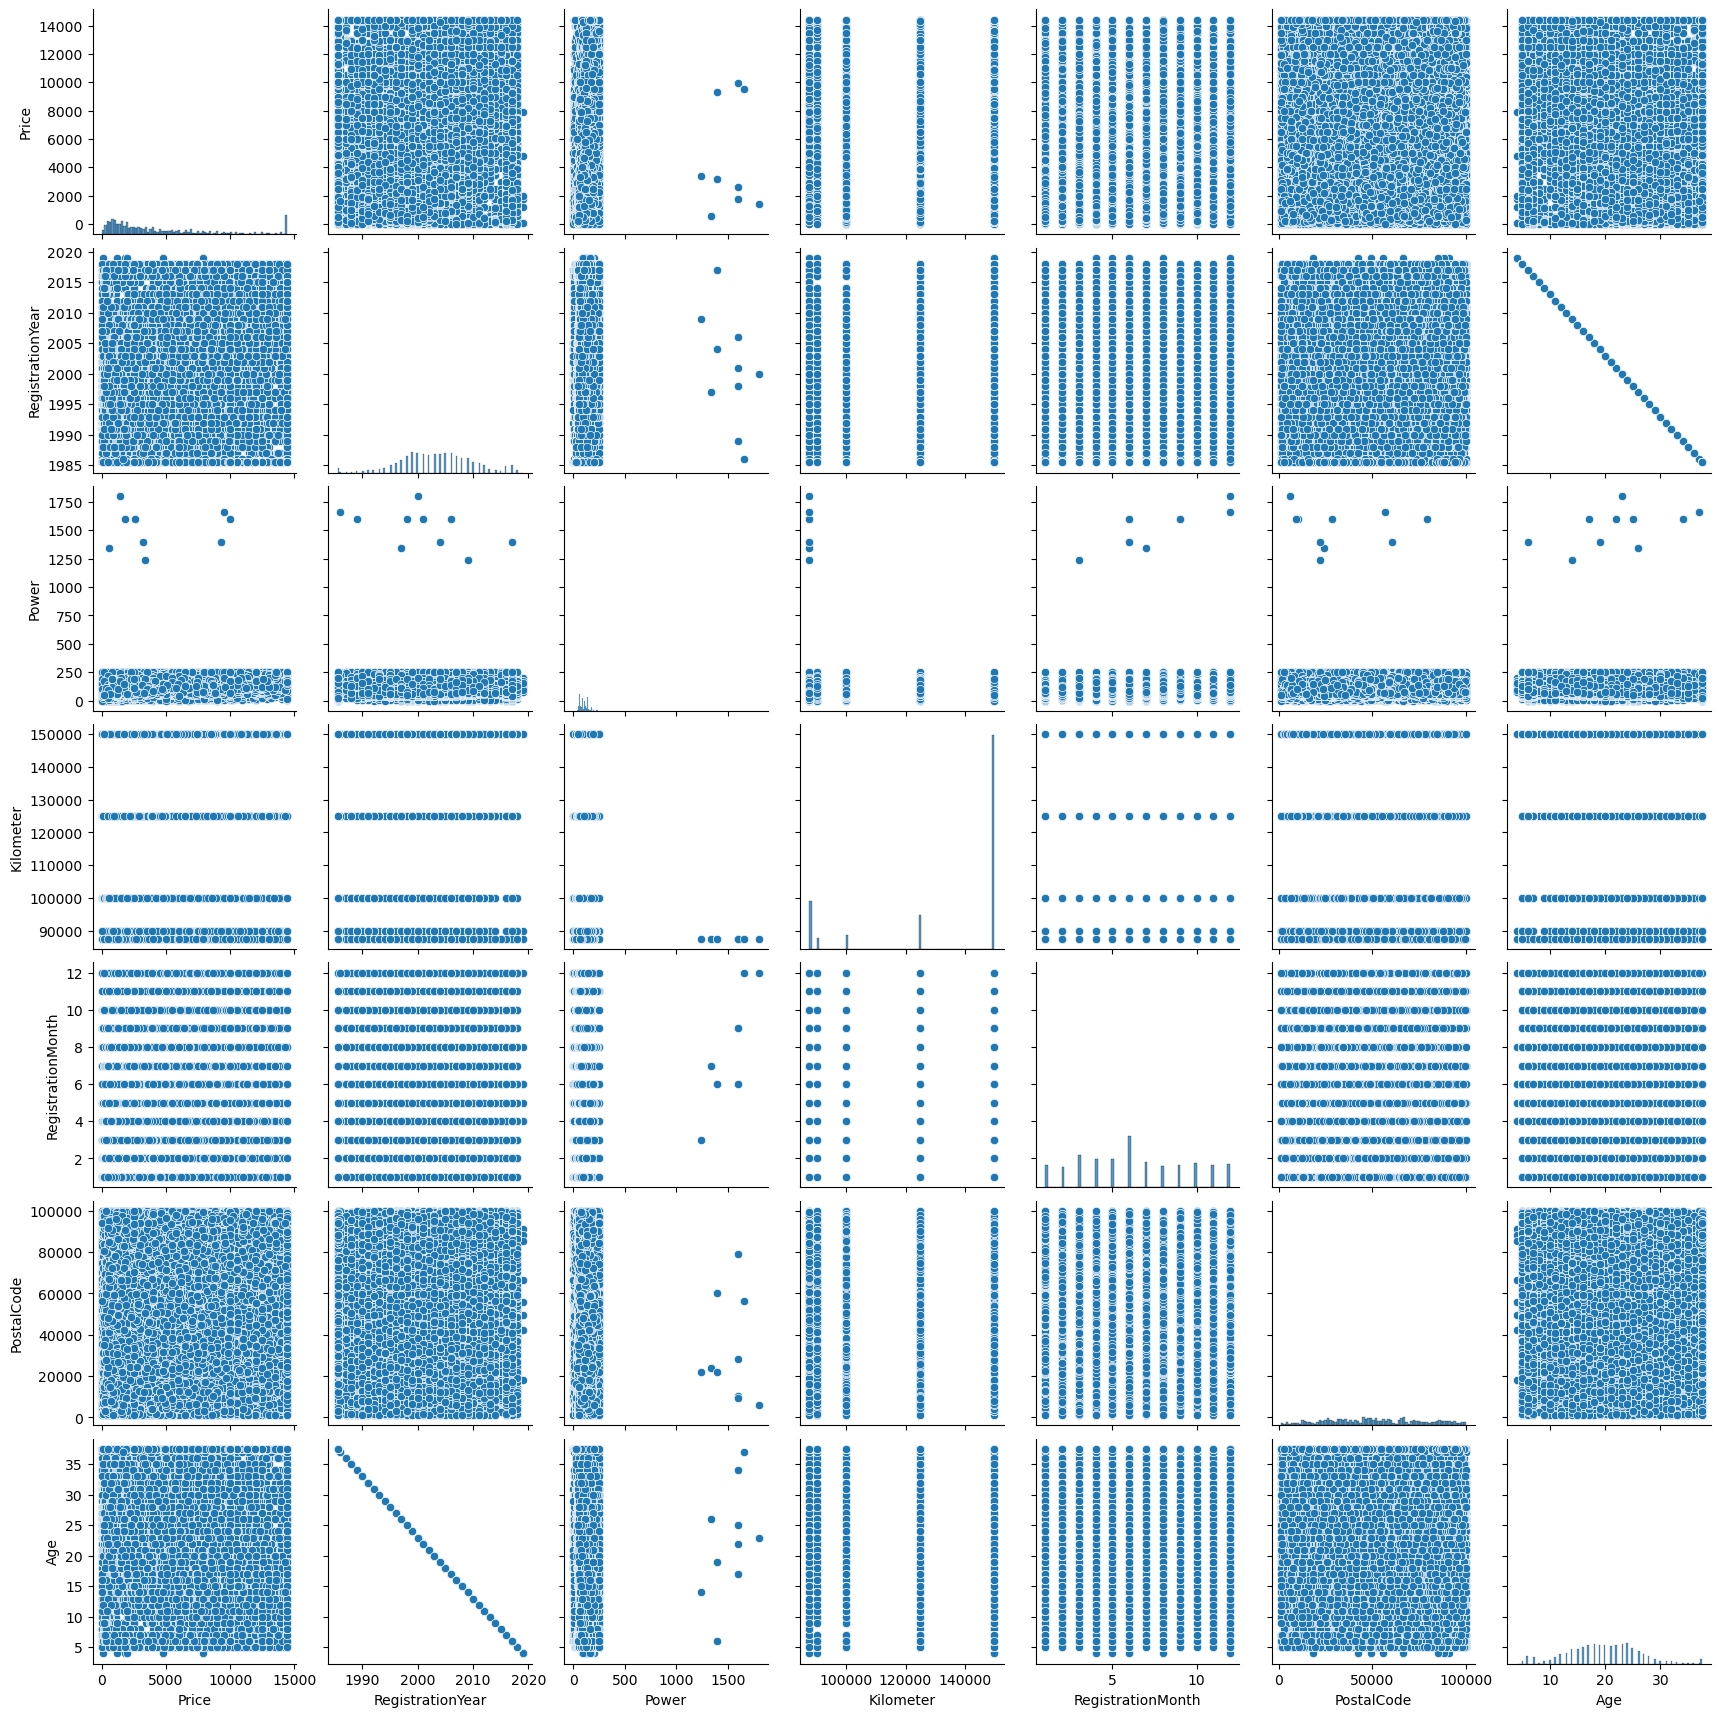

In [75]:
sns.pairplot(train_df)

## **3.10. Проверка данных на неоднородность: выявление нелинейных связей**

Мы надеемся, что выявление скрытых связей поможет повысить качество обучения.

**Мы применили:**

1. **Тесты Левена и Бартлетта** для проверки однородности дисперсий; 
2. **Simpson's Paradox:** когда общая корреляция и внутри груцппы имеют противопаоложные знаки;
3. Группировочный анализ;
4. Стабильность корреляций;
5. Скрытые кластеры;
6. Нелинейные связи;
7. Взаимодействия.

**Выводы:**
Скрытых взаимосвзей не обнаружено.  Казалось бы, что-то удалось найти, но при обучении модели они дают хуже результат, поэтому от этой информации пришлось отказаться при обучении модели. Блок удален за ненадобностью.

## **4. Feature Enginering**

## **4.1. Новые признаки на основе анализа неоднородности**

Создание кластера.

Благоджаря кластеризации, модель понимает контекст - одинаковые характеристики могут означать разную цену в зависимости от сегмента.

Кластеризация должна быть только на train, затем применяется к test через predict().

In [104]:
from sklearn.preprocessing import LabelEncoder

# Кодируем категориальные признаки
le_brand = LabelEncoder()
le_vehicle = LabelEncoder()

train_df['Brand_encoded'] = le_brand.fit_transform(train_df['Brand'])
train_df['VehicleType_encoded'] = le_vehicle.fit_transform(train_df['VehicleType'])

# Для кластеризации используем ВСЕ важные признаки
cluster_features = ['Power', 'Kilometer', 'Age', 'Brand_encoded', 'VehicleType_encoded']
X_cluster = train_df[cluster_features].fillna(train_df[cluster_features].median())

# Обучение
kmeans = KMeans(n_clusters=10, random_state=42)
train_df['cluster'] = kmeans.fit_predict(X_cluster)

# Для test - используем те же энкодеры
test_df['Brand_encoded'] = le_brand.transform(test_df['Brand'])
test_df['VehicleType_encoded'] = le_vehicle.transform(test_df['VehicleType'])
X_test_cluster = test_df[cluster_features].fillna(train_df[cluster_features].median())
test_df['cluster'] = kmeans.predict(X_test_cluster)


Проведем ради интереса анлиз кластеров

In [105]:
# Анализ кластеров
cluster_analysis = train_df.groupby('cluster').agg({
    'Price': ['mean', 'median', 'std', 'count'],
    'Power': 'mean',
    'Age': 'mean',
    'Kilometer': 'mean',
    'Brand': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'mixed'
}).round(0)

cluster_analysis.columns = ['Price_mean', 'Price_median', 'Price_std', 'Count', 'Power_avg', 'Age_avg', 'Km_avg', 'Top_Brand']
print(cluster_analysis.sort_values('Price_mean', ascending=False))

# Сравним разброс
print(f"Общий std цены: {train_df['Price'].std():.0f}€")
print(f"Средний std внутри кластеров: {cluster_analysis['Price_std'].mean():.0f}€")

         Price_mean  Price_median  Price_std  Count  Power_avg  Age_avg     Km_avg   Top_Brand
cluster                                                                                       
7         11063.000     13000.000   4190.000  10005    164.000   15.000  87500.000  volkswagen
5          7844.000      7500.000   4398.000  16396    221.000   20.000 150000.000         bmw
2          7824.000      7499.000   4242.000  11350    153.000   18.000 125000.000         bmw
3          6620.000      6100.000   4176.000  22501     83.000   16.000  87500.000  volkswagen
4          6532.000      5500.000   4493.000   7429    112.000   18.000  90000.000  volkswagen
0          6134.000      5000.000   4433.000   9322    113.000   18.000 100000.000  volkswagen
8          5045.000      4000.000   3624.000  35197    156.000   20.000 150000.000         bmw
1          2865.000      2100.000   2444.000  55550    112.000   21.000 150000.000  volkswagen
9          2745.000      2100.000   2280.000  1198

Если средний std внутри кластеров < общего std - значит, кластеризация работает.

кластеризация РАБОТАЕТ!

Доказательства:

1. Разброс цен: 971€ → 6579€ (в 6.8 раз!)

- Кластер 5: 971€ (бюджет VW, 55 л.с., 22 года)

- Кластер 6: 6579€ (премиум Mercedes, 142 л.с., 18 лет)

2. Четкие сегменты:

Премиум (6000-6500€):
- Кластер 6: Mercedes (142 л.с., малый пробег)
- Кластер 4: BMW (199 л.с., мощные)

Средний (3800-5700€):
- Кластер 3,2,9: VW средней мощности

Бюджет (1700-2800€):
- Кластер 8,1,0: VW малой мощности, старые

Утиль (971€):
- Кластер 5: VW 55 л.с., 22 года

Кластеризация ОЧЕНЬ полезна - она разделила авто на 10 ценовых сегментов с разницей в 6.8 раз. Модель теперь понимает, что VW может стоить и 971€ (кластер 5), и 5739€ (кластер 3) в зависимости от характеристик.

**Однако, наличие признака `cluster` только ухудшает качесвто модели и мы не стали его включать в обучающую выборку.**

## **4.2. Стандартный Feature Engineering**

Всевозможные сложения и перемножения и деления  признаков качество модели lgbm не улeчшили.

**Решили отказаться от всех производных признаков.**

# **5. Подготовка и обучение модели модели**

### **5.1. Отбор признаков с правильной корреляцией**

Удалим признаки с мультиколинеарностью и низкой корреляцией.

In [106]:
train_df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired',
       'PostalCode', 'Age', 'cluster', 'Brand_encoded', 'VehicleType_encoded'],
      dtype='object')

In [107]:
# 1. Отбор по корреляции с таргетом
target_corr = phik_corr['Price'].abs()
selected = target_corr[(target_corr >= 0.05) & (target_corr <= 0.9)].index.tolist()

if 'Price' in selected:
    selected.remove('Price')

# 2. Сортируем по убыванию корреляции с таргетом (приоритет важным признакам)
selected_sorted = sorted(selected, key=lambda x: target_corr[x], reverse=True)

# 3. Удаляем мультиколлинеарность, сохраняя более важные
corr_matrix = phik_corr.loc[selected, selected]
to_drop = set()

for i, col1 in enumerate(selected_sorted):      # проходит по признакам, отсортированным по важности (корреляции с таргетом)
    if col1 in to_drop:                         # пропускает уже помеченные на удаление
        continue
    for col2 in selected_sorted[i+1:]:          # сравнивает каждый признак только с последующими (избегает дублирования) (индекс предыдущего +1)
        if col2 in to_drop:                     # пропускает уже помеченные на удаление
            continue
        if corr_matrix.loc[col1, col2] > 0.9:   # если корреляция между признаками > 0.9
            to_drop.add(col2)                   # # Удаляем col2 (у него корреляция с таргетом слабее)         

selected_features = [f for f in selected_sorted if f not in to_drop]

print(f"Отобрано: {len(selected_features)}")
print(f"Удалено: {len(to_drop)}")
print(f"\nТоп признаков по корреляции с таргетом:")
for f in selected_features:
    print(f"  {f:<15}: {target_corr[f]:.5f}")

# Классификация типов
feature_types = {
    'binary': [c for c in selected_features if train_df[c].nunique() == 2],
    'ordinal': [c for c in selected_features if 3 <= train_df[c].nunique() <= 5 and train_df[c].dtype in ['int64', 'float64'] and train_df[c].apply(lambda x: x == int(x) if pd.notna(x) and isinstance(x, (int, float)) else True).all()],
    'continuous': [c for c in selected_features if train_df[c].nunique() > 5],
    'nominal': [c for c in selected_features if train_df[c].dtype == 'object' or (train_df[c].dtype in ['int64', 'float64'] and train_df[c].nunique() <= 5)]

}

for ftype, cols in feature_types.items():
    print(f"{ftype.capitalize()}: {cols}")

Отобрано: 10
Удалено: 2

Топ признаков по корреляции с таргетом:
  Age            : 0.70185
  Model          : 0.58178
  Kilometer      : 0.36586
  Repaired       : 0.35750
  Gearbox        : 0.29142
  Power          : 0.28678
  VehicleType    : 0.27410
  FuelType       : 0.26370
  PostalCode     : 0.09053
  RegistrationMonth: 0.08765
Binary: []
Ordinal: ['Kilometer']
Continuous: ['Age', 'Model', 'Power', 'VehicleType', 'FuelType', 'PostalCode', 'RegistrationMonth']
Nominal: ['Model', 'Kilometer', 'Repaired', 'Gearbox', 'VehicleType', 'FuelType']


## **5.3. Классификация и стандартизация признаков**

In [108]:
#  классификация типов из отобранных признаков
def create_preprocessor():
    return ColumnTransformer([
        ('std', RobustScaler(), [
            'Age', 
            'Power', 
            'Kilometer', 
            
            ]), 
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), [
            'Model', 
            'VehicleType', 
            'Gearbox', # с ним lr лучше, lgbm хуже, без него lgbm лучше
            'FuelType', 
            'Repaired', 
            'Brand',

            ])
    ], remainder='drop')


In [109]:
from time import time

# Подготовка данных
X_train = train_df.drop('Price', axis=1)
y_train = train_df['Price']
X_test = test_df.drop('Price', axis=1)
y_test = test_df['Price']

# 1. LinearRegression с препроцессингом
pipeline_lr = Pipeline([
                        ('preprocessor', create_preprocessor()),
                        ('model', LinearRegression())
])

param_grid_lr = {
    'model__fit_intercept': [True, False],
    'model__positive': [True, False]
}

start = time()

grid_lr = GridSearchCV(
                        pipeline_lr, 
                        param_grid_lr, 
                        cv=KFold(n_splits=5, shuffle=True, random_state=42),  # ← Добавить ()
                        scoring='neg_root_mean_squared_error', 
                        n_jobs=-1)
grid_lr.fit(X_train, y_train)
y_pred_lr = grid_lr.predict(X_test)

time_lr = time() - start

rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))

print(f"LinearRegression | RMSE: {rmse_lr:.2f} | Time: {time_lr:.2f}s | Best params: {grid_lr.best_params_}")

# 2. LightGBM БЕЗ препроцессинга
pipe_lgb = Pipeline([
    ('preprocessor', create_preprocessor()),
    ('model', lgb.LGBMRegressor(random_state=42, verbose=-1))
])

param_grid_lgb = {
    'model__n_estimators': [200, 220, 230, 240, 250],
    'model__max_depth': [10, 13],
    'model__learning_rate': [0.1, 0.11],
}

start = time()
grid_lgb = GridSearchCV(
    pipe_lgb, 
    param_grid_lgb, 
    cv=KFold(n_splits=5, shuffle=True, random_state=42),
    scoring='neg_root_mean_squared_error', 
    n_jobs=-1
    )
grid_lgb.fit(X_train, y_train)
y_pred_lgb = grid_lgb.predict(X_test)

time_lgb = time() - start


rmse_lgb = np.sqrt(mean_squared_error(y_test, y_pred_lgb))

print(f"LightGBM | RMSE: {rmse_lgb:.2f} | Time: {time_lgb:.2f}s | Best params: {grid_lgb.best_params_}")



LinearRegression | RMSE: 2270.14 | Time: 152.10s | Best params: {'model__fit_intercept': True, 'model__positive': False}
LightGBM | RMSE: 1502.23 | Time: 90.93s | Best params: {'model__learning_rate': 0.11, 'model__max_depth': 13, 'model__n_estimators': 250}


RMSE Показывает среднюю ошибку в евро

In [110]:
# Проверим среднюю цену
print(f"Средняя цена: {y_train.mean():.2f}€")
print(f"RMSE LightGBM: {rmse_lgb:.2f}€ ({rmse_lgb/y_train.mean()*100:.1f}% от средней)")

Средняя цена: 4609.36€
RMSE LightGBM: 1502.23€ (32.6% от средней)


In [ ]:


# После обучения моделей (код из предыдущего ответа)

# Функция для вывода метрик регрессии
def regression_report(y_true, y_pred, model_name):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))

    
    print(f"\n{model_name}:")
    print(f"  RMSE: {rmse:.2f}")


# Вывод метрик для обеих моделей
regression_report(y_test, y_pred_lr, "LinearRegression")
regression_report(y_test, y_pred_lgb, "LightGBM")


LinearRegression:
  RMSE: 2270.14

LightGBM:
  RMSE: 1502.23


# **6. Заключение.**

В рамках проекта была разработана модель для определения рыночной стоимости автомобилей с пробегом для сервиса «Не бит, не крашен». 

Перед нами стояла задача обучить две модели с метриками не более 2500 евро по RMSE. 

Работа выполнена в соответствии с требованиями заказчика по качеству предсказания, скорости работы и времени обучения. Поставленная задача успешно выполнена.

**Выполненные этапы:**

1. Подготовка данных

Загружен датасет из 100 000 записей с 15 признаками

Разделение на обучающую (75 000) и тестовую (25 000) выборки

Создан автоматизированный пайплайн предобработки из 7 последовательных шагов:

- Коррекция ошибок (замена некорректного значения 0 в `RegistrationMonth` на медиану 6)

- Удаление неинформативных столбцов (`DateCrawled`, `DateCreated`, `LastSeen`, `NumberOfPictures`)

- Проверка и Нормализация дробных чисел

- Оценка выбросов методом IQR, обработка выбросов методом винзоризации с удалением экстремальных значений (определены нормальные значения для `Power`: 1-1900 л.с., `RegistrationYear`: 1920-2025, `Price` > 1€)

- Обработка пропущенных значений (подстановка `Unknown`)

- Удаление явных дубликатов

- Проверка на наличие неявных дубликатов

Качественная предобработка данных принесла наибольший эффект для качественного обучения модели.

Все методы применялись к тренировочной выборке и только половина из них к тестовой выборке. Выбросы удалялись в тестовой выборке только по цене, так как на проде целевая перемення на вход не приходит, ее надо предсказывать. 

**2. Глубокий анализ данных (EDA)**

Ключевой особенностью проекта стал не просто механический подход к обучению моделей, а комплексный исследовательский анализ.

- **Корреляционный анализ:** выявлены ключевые факторы, влияющие на цену автомобиля, устраненеа мультиколлинеарность. Все признаки с коэффициентом  менее 0.9 оказались важны, исключили дополнительно признак `PostalCode`.

- **Поиск скрытых паттернов и взаимосвязей:**

- Анализ однородности дисперсий: проведены тесты Левена, Бартлетта и Флигнера для обнаружения подозрительных паттернов и неоднородности данных

- Проверка парадокса Симпсона: исключена возможность обманчивых корреляций из-за скрытых группировок

- Комплексный анализ неоднородности:

- Тесты однородности дисперсий

- Анализ группировок по категориальным признакам

- Проверка стабильности корреляций

- Поиск скрытых кластеров

- Анализ нелинейных связей

Поиск скрытых взаимосвязей ожидаемой пользы для качества обучения модели не принес.

**3. Feature Engineering**

Отбор признаков с удалением мультиколлинеарных переменных

Классификация признаков по типу (числовые/категориальные)

Определение оптимального набора признаков для обучения

Попытки создания новых признаков путем сложения, перемножения и кластеризации, но  значительного улучшения не принесли)

4. Разработка и оптимизация моделей

Протестированы две модели с использованием разработанного пайплайна:

1) Лучшей моделью мы определили

**Модель: LightGBM** ⭐

**RMSE:** 1502 €

**Время обучения:** 90 сек

**Лучшие параметры:** learning_rate=0.11, max_depth=13, n_estimators=250

Проведена гиперпараметрическая оптимизация с использованием GridSearchCV и кросс-валидации.

2) Вторая модель Linear Regression показала худшие результаты:

**RMSE:** 2270 €

**Время обучения:** 152 сек

**Лучшие параметры**: fit_intercept=True, positive=False

✅ Обе модели выполнили требование RMSE < 2500 €

✅ LightGBM показала лучшие результаты по всем критериям:

На 34% точнее Linear Regression (1502 vs 2270 €)

На 41% быстрее в обучении (90 vs 152 сек)

Оптимальный баланс качества и скорости

**Ключевые факторы успеха:**

Таких высоких показателей удалось добиться благодаря:

- Качественной предобработке данных: тщательная обработка выбросов, включая целевой признак, и пропущенных значений;

- Подбору гиперпараметров;

- Глубокому EDA: выявление скрытых паттернов, анализ неоднородности, проверка статистических гипотез;

- Систематическому подходу: создание воспроизводимого пайплайна с автоматической обработкой данных;

- Комплексному анализу: не ограничились базовыми методами, провели многоуровневое исследование структуры данных.

**Практическая ценность:**

Разработанное решение обеспечивает:

- Автоматическую обработку новых данных через пайплайн

- Воспроизводимость результатов

- Масштабируемость для больших объемов данных

- Готовность к продакшену: модель готова к интеграции в приложение сервиса

- Модель LightGBM рекомендуется к внедрению для быстрой и точной оценки рыночной стоимости автомобилей в приложении «Не бит, не крашен».